# This is a quick start demo for "nwnTorch" as of 24 Apr 2023.

Ruomin Zhu      rzhu0837@uni.sydney.edu.au

[Twitter](https://twitter.com/RuominZhu)

In [40]:
import sys

In [41]:
# NOTE I found this the easiet way to include the scripts I wrote.
# * Append the PARENT directory of nwnTorch to path
sys.path.append("/home/rzhu/Documents/nwn_l2l/")

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

## Set up network

### Connectivity

In [69]:

# * con is a pre-generated connectivity file. 
# * 1024 nodes, 6877 edges.
# * Have a look at wires.py and nwnTorch.generate_adj for more details.
con = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con0.pkl")
# * Get the adjacency matrix from the file.
adj = torch.tensor(con["adj_matrix"])

# * Generate network class. 
# * See nwnTorch.jn_models for other types of junctions.
net = NWN(adj, "sydney")

### Parameters

In [76]:

# * The parameters for the network and the junctions are all contained in net.params
net.params["Ron"]       = 1e4
net.params["Roff"]      = 1e7
net.params["grow"]      = 5
net.params["decay"]     = 10
net.params["precision"] = True
net.params["collapse"]  = False
net.params["dt"]        = 1e-3

# * One can initialize the network to different states by manipulate L.
# ! Note that this method is not highly recomanded. 
# ! Mainly because it's not physically relizable.
E                    = net.number_of_junctions
net.junction_state.L = torch.rand(E) * 0.3 - 0.15

# * The following line is not necessary. For visualization reasons we do it here.
# * The simulator is able to update it inside the loop.
net.junction_state.updateG()

Text(0.5, 0, '$\\log_{10}(junction \\, conductance)$')

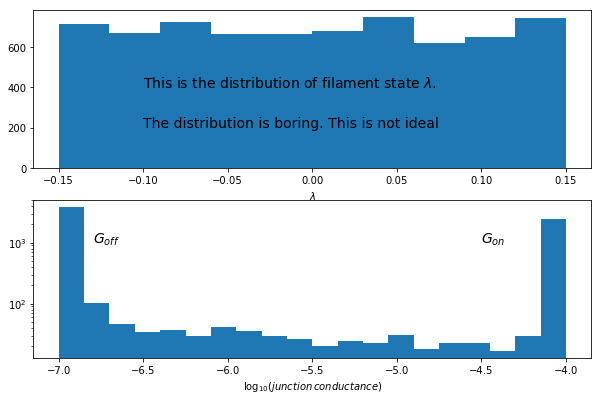

In [79]:
fig, axes = plt.subplots(2,1, figsize = (10,6.4))

axes[0].hist(net.junction_state.L)
axes[0].set_xlabel(r"$\lambda$")
axes[0].text(-0.1, 400, r"This is the distribution of filament state $\lambda$.",
             fontsize = 14)
axes[0].text(-0.1, 200, "The distribution is boring. This is not ideal", 
            fontsize = 14)

axes[1].hist(np.log10(net.junction_state.G), 20)
axes[1].set_yscale("log")
axes[1].text(-6.8, 1000, r"$G_{off}$", fontsize = 14)
axes[1].text(-4.5, 1000, r"$G_{on}$", fontsize = 14)
axes[1].set_xlabel(r"$\log_{10}(junction \, conductance)$")
# axes[1].set_title("Conductance distribution")


## Set up input/output

In [80]:

# * Often times we use a 2-terminal set up to mimick physical device.
# * One electrode(node) for input and the other is grounded.
# * The voltage distribution of the network is read out from various nodes, \
# * as if we have a voltage probe going around the physical network.

# * Here we try to use 2 graphically furthest nodes for source/drain
distMat = graphical_distance(net.adjMat)
E1, E2  = np.stack(np.where(distMat == distMat.max())).T[0]
E_read  = np.random.permutation(1024)[:64]
elecs   = torch.tensor([E1, E2])
# sig     = torch.sin(2*torch.pi * torch.arange(0,10,1e-3))
sig  = torch.ones(1000)

## Run Simulation

In [73]:

# * Number of steps we want to simulate
steps = 1000
readV = torch.zeros(steps, len(E_read))
readL = torch.zeros(steps, E)
netG  = torch.zeros(steps)
netG2 = torch.zeros(steps)


# * We use a for-loop for simulation.
# * Should wrap all these into a Class but haven't done that.
# * Would really appreciate contributions.
for t in tqdm(range(steps)):
    # * Each electrode needs to have a corresponding signal. In this case we need 2.
    # * If the number of signals provided is less than the number of electrodes,
    # * the module can extend it by zeros. But there will be annoying notifications.

    # NOTE sig_in should be of shape (T,E).
    # * Here we use T=1 so we can collect data for each step.
    sig_in = torch.zeros(1,2) 

    # * We can adjust the signal if necessary. 
    # * This could also be done outside the loop. Your choice!
    sig_in[0,0] = sig[t] * 2 + 0.02

    # * This line calls the simulation method.
    net.sim(sig_in, elecs)

    # * We are trying to keep track of the features.
    # * Note that keeping all of them might take too much RAM. Be selective.
    readV[t,:] = net.V[E_read] # * Voltage
    readL[t,:] = net.junction_state.L # * filament state (lambda)

    # * We use this function to keep track of the collective conductance of the network.
    # NOTE This thing might not make enought sense if it's not two terminal.
    # NOTE Still, it will be nice indicator for what's going on.
    netG[t] = net.test_conductance(elecs) 
    netG2[t] = net.I[1] / sig_in[0,0]

# * A list of things you might be interested in.
print(net.junction_state.__dict__.keys())

100%|██████████| 1000/1000 [00:13<00:00, 74.72it/s]

dict_keys(['params', 'V', 'G', 'L', 'switch'])
